In [1]:
import pygsp
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import scipy
import pyshtools
from deepsphere.utils import healpix_graph
import sys
from pygsp.graphs import NNGraph
import pickle

In [2]:
opt_std =  {1:1.097324009878543,
            2:1.097324042581347,
            4: 0.5710655156439823,
            8: 0.28754191240507265,
            16: 0.14552024595543614,
            32: 0.07439700765663292,
            64: 0.03654101726025044,
            128: 0.018262391329213392,
            256: 0.009136370875837834,
            512: 0.004570016186845779,
            1024: 0.0022857004460788742,}

In [3]:
from pygsp.graphs import SphereHealpix

0.10000000000000006


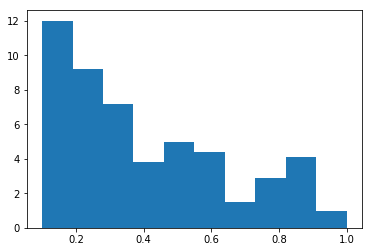

0.10000000000000006


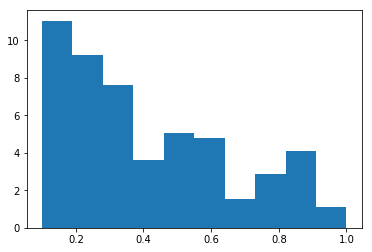

0.10000000000000006


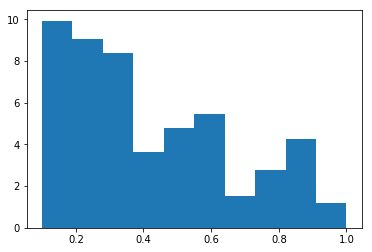

0.10000000000000006


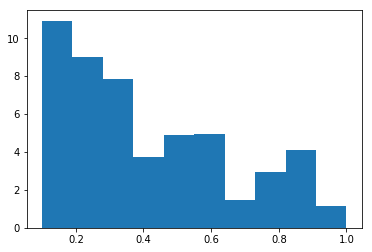

0.10000000000000006


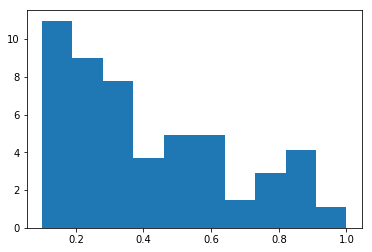

0.10000000000000006


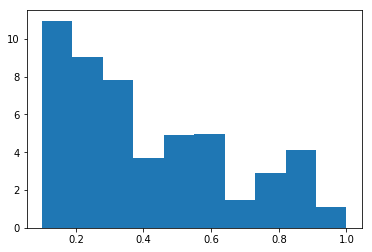

In [4]:
def kernel(distances, t):
        cst = np.log(0.5)
        weights = np.exp(cst*(distances/t)**2).flatten()
        return weights, np.min(weights)


for nside in 2**np.arange(3,9):
    sphere = SphereHealpix(nside=nside, n_neighbors=50, kernel_width=opt_std[nside])
    weights, m = kernel(sphere.distances, opt_std[nside])
    print(m)
    npix = 12*nside**2
    nbins=10
    plt.hist(weights, bins=nbins, weights=np.ones(len(weights))/npix);
    plt.show()

In [5]:
degree_step = {
            32: 10,
            64: 10,
            128: 50,
            256: 50,
            512: 100,
            1024: 200,    
}

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = None

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout
   

In [6]:
plt.rcParams['figure.figsize'] = (17, 5)  
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

In [7]:
def rotate_NEST(hmap, rot):
    return hp.reorder(rot.rotate_map_alms(hp.reorder(hmap, n2r=True)), r2n=True)


def _equivariance_error(hmap, max_iter, _filter, lmax, nside):
    """Calculates the equivariance error on one signal only
    as average of max_iter random rotations
    
    hmap is in NEST ordering"""

    
    angles = np.random.uniform(low=0, high=360, size=(max_iter, 3))
    norm = np.zeros(max_iter)
    
    for i, [alpha, beta, gamma] in enumerate(angles):
      
        rot = hp.rotator.Rotator(rot=[alpha, beta, gamma])
        R_hmap = rotate_NEST(hmap, rot)
        FR_hmap = _filter(R_hmap)
        # ------ first filter, then rotate ------
        F_hmap = _filter(hmap)
        RF_hmap = rotate_NEST(F_hmap, rot)
        norm[i] = np.linalg.norm(RF_hmap-FR_hmap)
            
    filtered_norm = np.linalg.norm(F_hmap)      
    return np.mean(norm)/filtered_norm


def equivariance_error(max_iter, _filter, lmax, nside, degree=None):
    """Calculates the equivariance error on max_iter signals
    with the same power spectrum as average of N random rotations each"""
   
    N = 5
    np.random.seed(seed=1994)
    degrees = np.arange(lmax+1, dtype=float)

    degrees[0] = np.inf

    power = degrees**(-3) 
    if degree is not None:
        assert degree < lmax+1
        power = np.zeros(lmax+1)
        power[degree] = 1
    norm = np.zeros(max_iter)
    for i in range(max_iter):
        hmap = hp.sphtfunc.synfast(power, nside=nside)  ## this is RING ORDERED
        hmap = hp.reorder(hmap, r2n=True)
        norm[i] = _equivariance_error(hmap, N, _filter, lmax, nside)
    return np.mean(norm)


In [15]:
nsides = [32, 64]#, 128, 256, 512]# 1024]

# 4) Grid search on kernel width

### Everything works fine!
However, we were using the original DeepSphere graph. we want to do the same with more neighbors and __then__ sparsify the graph. Let's now use the SphereHealpix class of Frederick

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.024996042676954985 0.07093018952223995
0.03185183192481174 0.022695235993584223
0.040587992670608114 0.0098260155698155


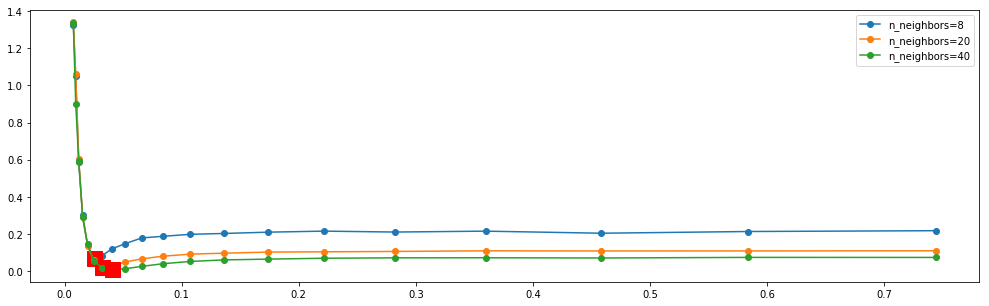

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
0.012277117799040067 0.07854645810449373
0.015644424107847475 0.023485493858802605
0.019935298306361107 0.007662555352650286


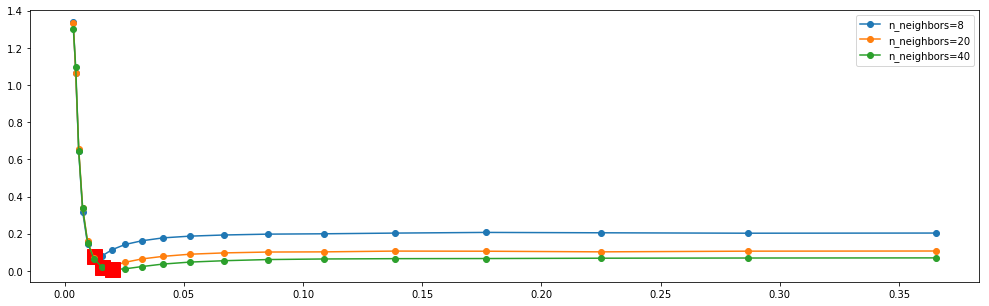

In [16]:
equiv_error = dict()

for nside in nsides:
    equiv_error[nside] = dict()
    
    # generating hmaps (red noise)
    lmax = 3*nside-1
    degrees = np.arange(lmax+1, dtype=float)
    degrees[0] = np.inf
    power = degrees**(-3)  # red noise
    hmap = hp.sphtfunc.synfast(power, nside=nside)
    hmap = hp.pixelfunc.reorder(hmap, r2n=True)

    # std deviations to try
    min_std = opt_std[nside]/10
    max_std = opt_std[nside]*10
    kernels = np.logspace(np.log10(min_std), np.log10(max_std), 20)

    for n_neighbors in [8, 20, 40]:
        
        equiv_error[nside][n_neighbors] = np.empty(len(kernels))
        for i, kernel_width in enumerate(kernels):

            sphere = SphereHealpix(nside=nside, nest=True, n_neighbors=n_neighbors, lap_type='combinatorial', kernel_width=kernel_width)
            # WARNING: healpix graph is in NEST ordering
            HKGL_filter = sphere.L

            def diffuse_HKGL(x):
                """x is in NEST order, must return result in NEST order"""
                return HKGL_filter@x

            with HiddenPrints():
                equiv_error[nside][n_neighbors][i] = _equivariance_error(hmap, 5, diffuse_HKGL, lmax, nside);

            del(sphere)

        plt.plot(kernels, equiv_error[nside][n_neighbors], 'o-', label="n_neighbors={}".format(n_neighbors))
        j = np.argmin(equiv_error[nside][n_neighbors])
        plt.plot(kernels[j], equiv_error[nside][n_neighbors][j], 'rs', markersize=15)
        plt.legend()
        print("nside={}, best kernel = {}".format(nside,kernels[j]))
    plt.show()
        
#filename = "new_normalisation_grid_search.pickle"
#filehandler = open(filename, 'wb') 
#pickle.dump(equiv_error, filehandler)

In [17]:
opt_std =  {1:1.097324009878543,
            2:1.097324042581347,
            4: 0.5710655156439823,
            8: 0.28754191240507265,
            16: 0.14552024595543614,
            32: 0.07439700765663292,
            64: 0.03654101726025044,
            128: 0.018262391329213392,
            256: 0.009136370875837834,
            512: 0.004570016186845779,
            1024: 0.0022857004460788742,}

opt = dict()
for n_neighbors in [8, 20, 40]:
    opt[n_neighbors] = dict()
    for nside in nsides:
        min_std = opt_std[nside]/10
        max_std = opt_std[nside]*10
        kernels = np.logspace(np.log10(min_std), np.log10(max_std), 20)
        opt[n_neighbors][nside] = kernels[np.argmin(equiv_error[nside][n_neighbors])]

In [18]:
opt

{8: {32: 0.024996042676954985, 64: 0.012277117799040067},
 20: {32: 0.03185183192481174, 64: 0.015644424107847475},
 40: {32: 0.040587992670608114, 64: 0.019935298306361107}}

# 5) Re-define V2 with these minima (already done in the pygsp)

In [26]:
def plot_equivariance_error_by_degree(graph='V1', nsides = [32, 64, 128], n_neighbors=None, save=False, title='Equivariance Error'):
    equiv_error = dict()
    for nside in nsides:
        lmax = 3*nside-1
        
        if graph=='V2':
            sphere = SphereHealpix(nside=nside, nest=True, lap_type='combinatorial', n_neighbors=n_neighbors)
        else:
            sphere = healpix_graph(nside=nside, nest=True, lap_type='combinatorial')
        
        def diffuse_HKGL(hmap):
            """hmap must be in NEST ordering"""
            return sphere.L@hmap

        degrees = np.arange(0, lmax+1, degree_step[nside])
        equiv_error[nside] = np.zeros(len(degrees))
        for i, degree in enumerate(degrees):
            if not i:
                equiv_error[nside][i] = 0
            else:
                with HiddenPrints():
                    equiv_error[nside][i] = equivariance_error(5, diffuse_HKGL, lmax,nside, degree=degree)
        plt.plot(degrees, equiv_error[nside], 'o-', label='nside={}'.format(nside))

    plt.xlabel('Degree', fontdict=font)
    plt.ylabel('Equivariance Error', fontdict=font)
    plt.title(title, fontdict=font)

    plt.grid()
    plt.legend()
    plt.savefig(title+".pdf")
    plt.show()
    
    if save:
        filename = title+".pickle"
        filehandler = open(filename, 'wb') 
        pickle.dump(equiv_error, filehandler)

In [27]:
nsides = [32, 64, 128]#, 256, 512]

# V1

/home/martino/miniconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/home/martino/miniconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/home/martino/miniconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/home/martino/miniconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new

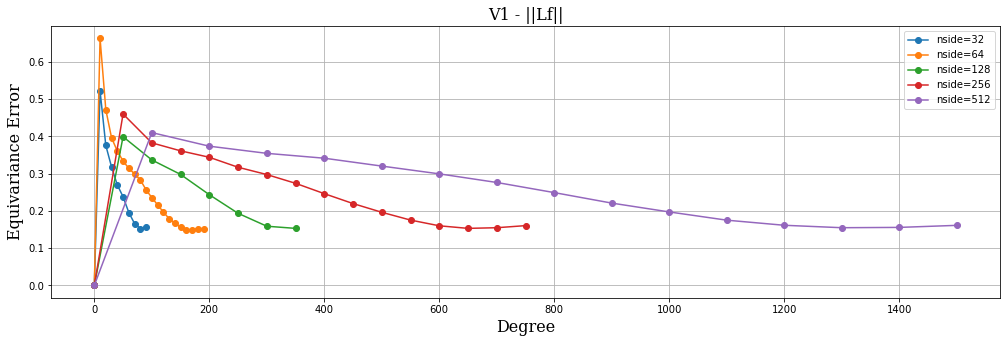

In [15]:
#plot_equivariance_error_by_degree(graph='V1', title='V1 - ||Lf||', nsides=nsides, save=True)
plot_equivariance_error_by_degree(graph='V1', title='V1 - ||Lf||', nsides=nsides, save=False)

# V2: 
### 40 neighbors

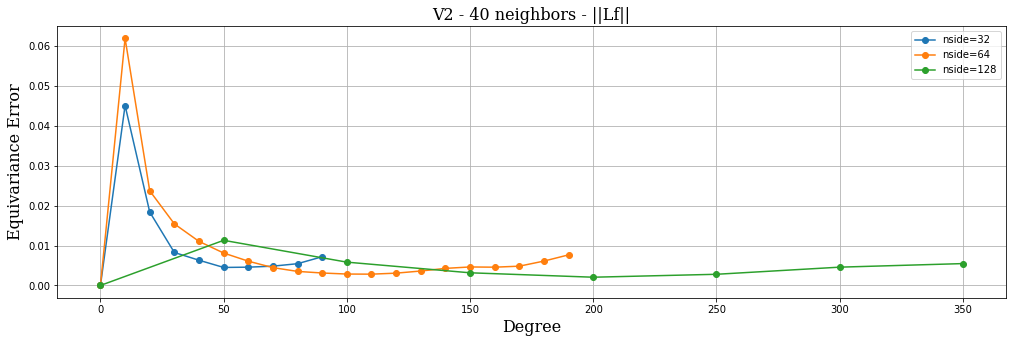

In [29]:
plot_equivariance_error_by_degree(graph='V2', n_neighbors=40, save=False, title='V2 - 40 neighbors - ||Lf||', nsides=nsides)

### 20 neighbors

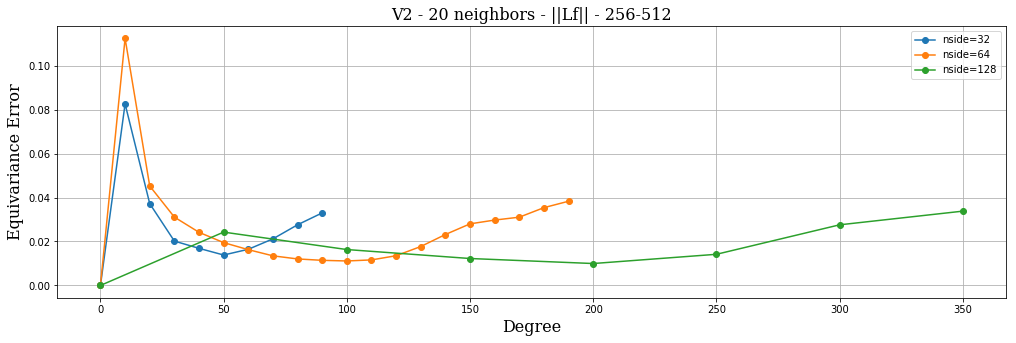

In [31]:
plot_equivariance_error_by_degree(graph='V2', n_neighbors=20, save=False, title='V2 - 20 neighbors - ||Lf|| - 256-512', nsides=nsides)

### 8 neighbors

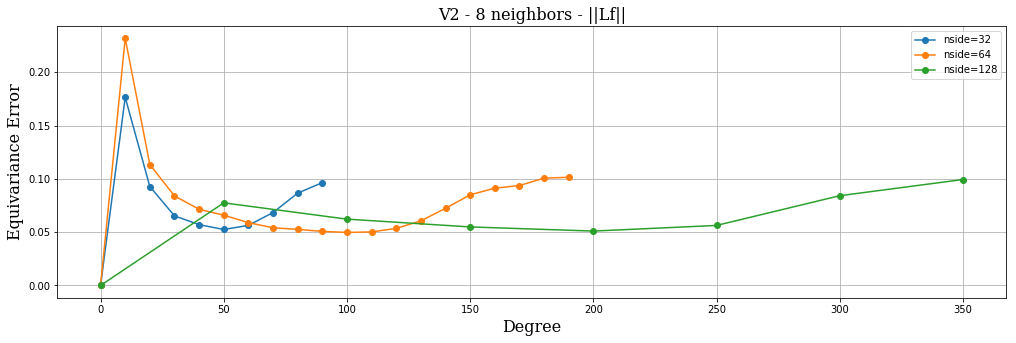

In [32]:
plot_equivariance_error_by_degree(graph='V2', n_neighbors=8, save=False, title='V2 - 8 neighbors - ||Lf||')

# 7) Equivariance error of Khasanova-Frossard

In [27]:
from pygsp.graphs import Graph
from scipy import sparse

class SphereEquiangularFrossard(Graph):
    def __init__(self, bw=64, sptype='DH', pole='all', neighbors=4, weights=None, dist=None, 
                 affine=0., **kwargs):
        """Sphere with an equiangular sampling
         Parameters
        ----------
        bw : int
            bandwidth, size of grid  (default = 64)
        sptype: str
            sampling type, possible arguments are 'DH', 'SOFT', ... (default = 'DH')
        pole: str
            how to manage the pole of the sphere, possible arguments are 'all', 'one', 'zero' (default = 'all')
        ---------
        TODO: unique on neighbor
        TODO: CC and GL are not equiangular and must be implement in other ways
        """
        self.bw = bw
        self.sptype = sptype
        self.pole = pole
        if pole not in ['all', 'one', 'zero']:
            raise ValueError('Unknown pole value:' + pole) 
        if sptype is not 'DH' and pole is not 'zero':
            print('pole can be only zero with sampling type ' + sptype)
            pole = 'zero'
        
        ## sampling and coordinates calculation
        if sptype is 'DH':
            beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
            alpha = np.arange(2 * bw) * np.pi / bw
            if pole is 'zero':
                beta = np.arange(2 * bw + 1) * np.pi / (2. * bw + 1)
        if pole is not 'all' and sptype is 'DH':
            beta = beta[1:]
        
        theta, phi = np.meshgrid(beta, alpha,indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        
        if pole is 'one':
            coords = np.vstack([[0., 0., 1.],coords])
        coords = np.asarray(coords, dtype=np.float32)
        
        ## neighbors and weight matrix calculation
        def south(x, bw):
            if x >= (2*bw)*(2*bw-1):
                return north((x+bw)%(2*bw)+(2*bw)*(2*bw),bw)
            elif self.pole is 'zero' and x >= (2*bw)*(2*bw-1):
                return north((x+bw)%(2*bw)+(2*bw)*(2*bw-1),bw)
            else:
                return x + 2*bw

        def north(x, bw):
            if x < 2*bw:
                return (x+bw)%(2*bw)
            else:
                return x - 2*bw

        def west(x, bw):
            if x%(2*bw)==0:
                x += 2*bw
            return x -1

        def east(x, bw):
            if x%(2*bw)==2*bw-1:
                x -= 2*bw
            return x + 1

        npix = len(coords)
        col_index=[]
        for ind in range(len(coords)):
            # first line is the same point, so is connected to all points of second line
            if pole is 'all' and sptype and ind < 2* bw:
                if ind == 0:
                    neighbor = np.arange(2*bw)+2*bw # np.arange(1,4*bw)
                else:
                    neighbor = np.arange(2*bw)+2*bw # [0]
            elif pole is 'all' and ind < 4*bw:
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
                neighbor += list(range(2*bw)) # [0]
            elif pole is 'one' and ind == 0:
                neighbor = np.arange(1, 2*bw+1)
            elif pole is 'one' and ind < 2*bw+1:
                ind += 2*bw - 1
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
                neighbor += [0]
            else:
                if pole is 'one':
                    ind += 2*bw - 1
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), north(west(ind,bw), bw), north(ind,bw), 
                                north(east(ind,bw),bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), north(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
            neighbor = np.asarray(neighbor)
            if pole is 'one' and ind != 0:
                neighbor -= 2*bw - 1
                neighbor[neighbor<0] = 0
            #neighbors.append(neighbor)
            col_index += list(neighbor)
        # neighbors = np.asarray(neighbors)
        col_index = np.asarray(col_index)

        #col_index = neighbors.reshape((-1))
        if pole is 'all':
            row_index = np.hstack([np.repeat(np.arange(0,2*bw), 2*bw), np.repeat(np.arange(2*bw,4*bw), neighbors//2+1+2*bw),#2*bw+5), 
                                  np.repeat(np.arange(4*bw, npix), neighbors)])
        elif pole is 'one':
            row_index = np.hstack([np.repeat(0, 2*bw), np.repeat(np.arange(1, 2*bw+1), neighbors//2+2),
                                  np.repeat(np.arange(2*bw+1, npix), neighbors)])
        elif pole is 'zero':
            row_index = np.repeat(np.arange(npix), neighbors)

        distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
        
        weights = 1/distances

        # Build the sparse matrix.
        W = sparse.csr_matrix(
            (weights, (row_index, col_index)), shape=(npix, npix), dtype=np.float32)
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(SphereEquiangularFrossard, self).__init__(adjacency=W, coords=coords,
                                     plotting=plotting, **kwargs)

### 7.0) sanity check: rotations around the isolatitude rings

### check on to_signal and resize

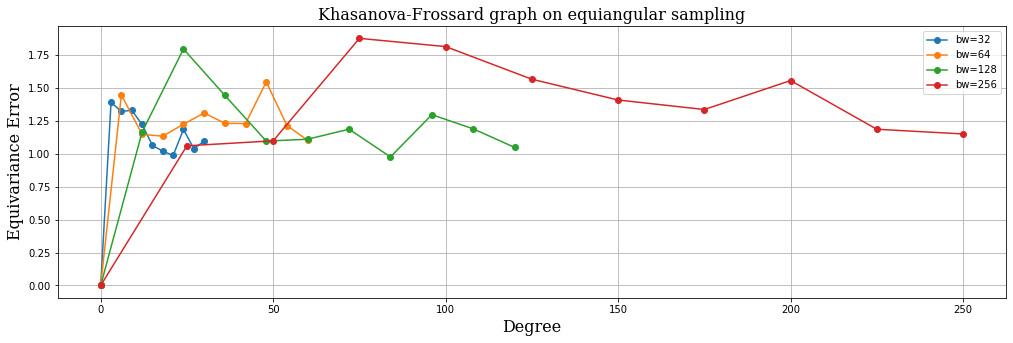

In [30]:
def _equivariance_error(clm, max_iter, _filter, plot, save):
    """Calculates the equivariance error on one signal  only
    as average of max_iter random rotations"""
    
    angles = np.random.uniform(low=0, high=360, size=(max_iter, 3))
    grid = clm.expand(grid='DH')
    F_grid = _filter(grid)
    F_clm = F_grid.expand()

    norm = np.zeros(max_iter)
    for i, [alpha, beta, gamma] in enumerate(angles):
        
        RF_clm = F_clm.rotate(alpha, beta, gamma, degrees=True)
#         RF_clm = F_clm.rotate(alpha, 0, 0, degrees=True)
#        RF_clm = F_clm.rotate(0, 0, gamma, degrees=True)
#         RF_clm = F_clm.rotate(0, 0, 360/64, degrees=True)
        RF_data = RF_clm.expand(grid='DH').data.flatten()

        clm_rotated = clm.rotate(alpha, beta, gamma, degrees=True)
#         clm_rotated = clm.rotate(alpha, 0, 0, degrees=True)
#         clm_rotated = clm.rotate(0, 0, 360/64, degrees=True)
#        clm_rotated = clm.rotate(0, 0, gamma, degrees=True)
    
        grid_rotated = clm_rotated.expand(grid='DH')
        FR_clm = _filter(grid_rotated)
        FR_grid = FR_clm.expand()
        FR_data = FR_grid.expand(grid='DH').data.flatten()
        
        norm[i] = np.linalg.norm(RF_data-FR_data)
    
    initial_norm = np.linalg.norm(F_clm.expand(grid='DH').data.flatten())
    return np.mean(norm)/(initial_norm+ 1e-3)


def equivariance_error(max_iter, _filter, plot=False, save=False, degree=None):
    """Calculates the equivariance error on max_iter signals
    with the same power spectrum as average of N random rotations each"""
    N = 5
    np.random.seed(seed=1994)
    assert(degree is not None)
    
    if degree is not None:
        assert degree < lmax
        power = np.zeros(lmax)
        power[degree] = 1
    norm = np.zeros(max_iter)
    if degree==0:
        return 0
    for i in range(max_iter):
        clm = pyshtools.SHCoeffs.from_random(power)
        norm[i] = _equivariance_error(clm, N, _filter, plot, save)
            
    return np.mean(norm)

degree_step = {
    4: 1,
    8: 2,
    16: 4,
    32: 3,
    64: 6,
    128: 12,
    256: 25,
    512: 50,
}

bws = [32, 64, 128, 256]


equiv_error = dict()

for bw in bws:
    lmax = bw
    
    sphere = SphereEquiangularFrossard(bw=bw, lap_type='combinatorial')
    KF = sphere.L

    def _filter_KF(grid):
        array = grid.data
        f = array.flatten()
        ### here goes the filtering ###
        f = KF@f
        ### ----------------------- ###
        array = np.resize(f, array.shape)
        return pyshtools.SHGrid.from_array(array)
    
    degrees = np.arange(0, lmax, degree_step[bw])    
    
    equiv_error[bw] = np.zeros(len(degrees))
    for i, degree in enumerate(degrees):
        equiv_error[bw][i] = equivariance_error(20, _filter_KF, plot=False, save=False, degree=degree)
    plt.plot(degrees, equiv_error[bw], 'o-', label='bw={}'.format(bw))
    
plt.xlabel('Degree', fontdict=font)
plt.ylabel('Equivariance Error', fontdict=font)
plt.title('Khasanova-Frossard graph on equiangular sampling', fontdict=font)
plt.grid()
plt.legend()

filename = "khasanova_frossard.pickle"
filehandler = open(filename, 'wb') 
pickle.dump(equiv_error, filehandler)

### 0 rotations

/home/martino/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


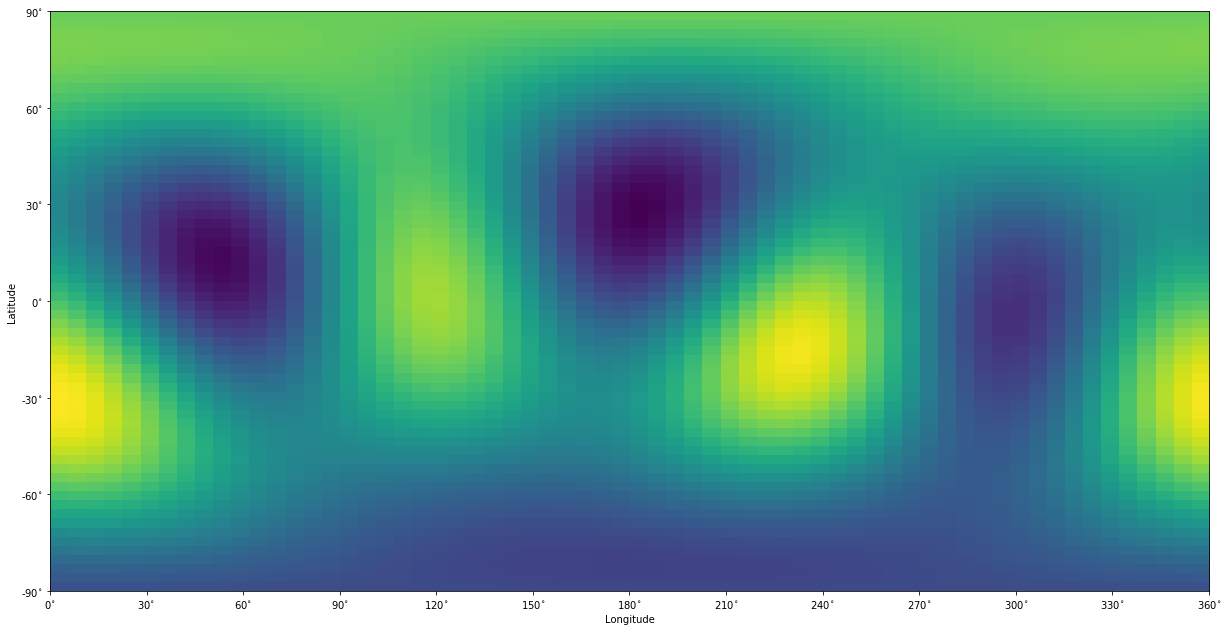

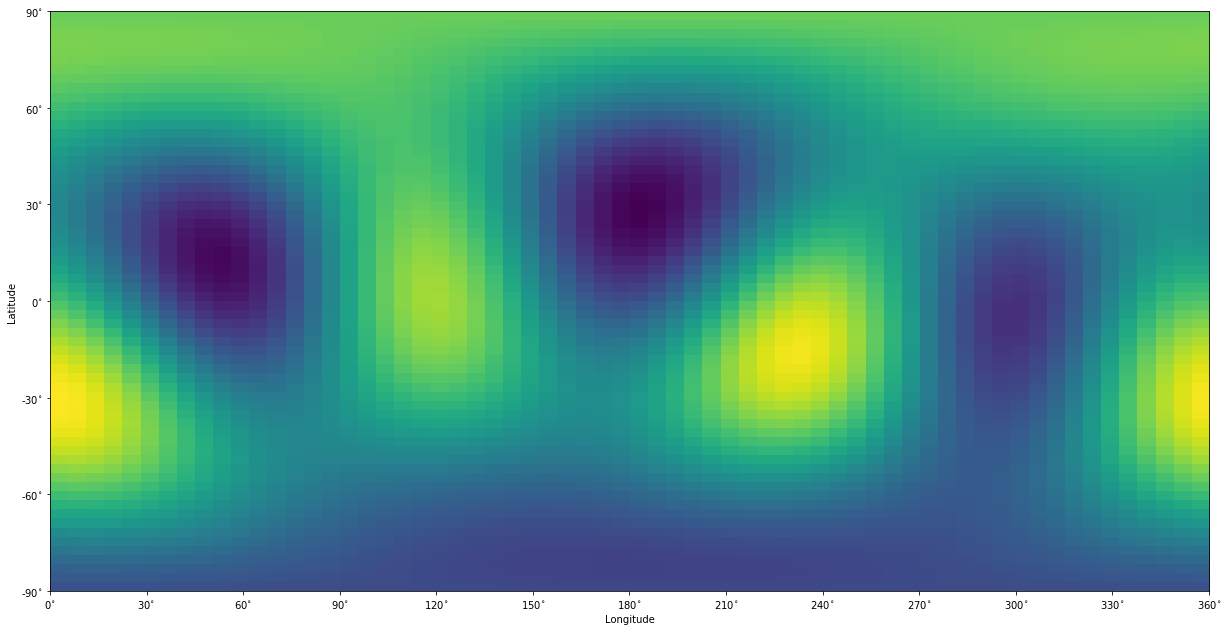

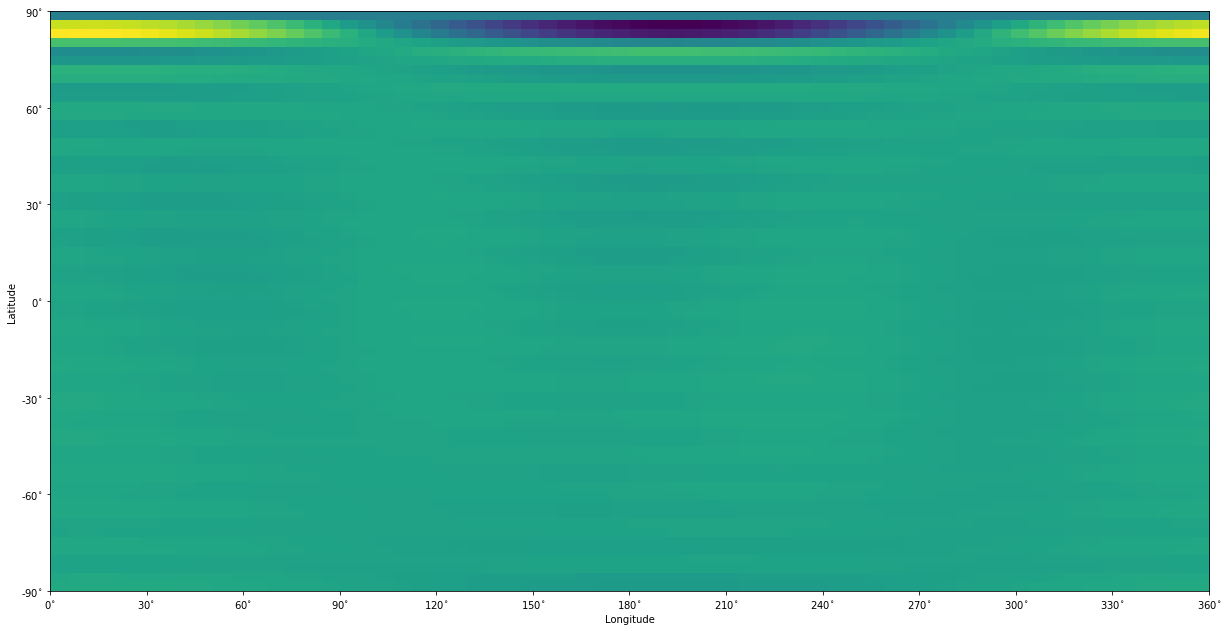

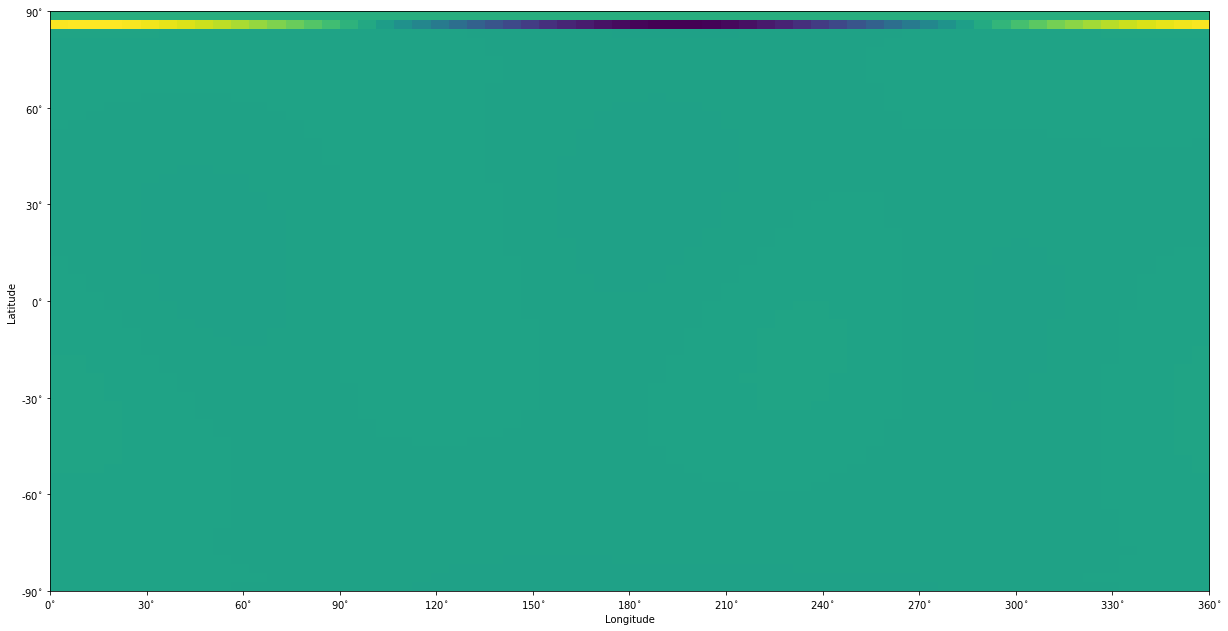

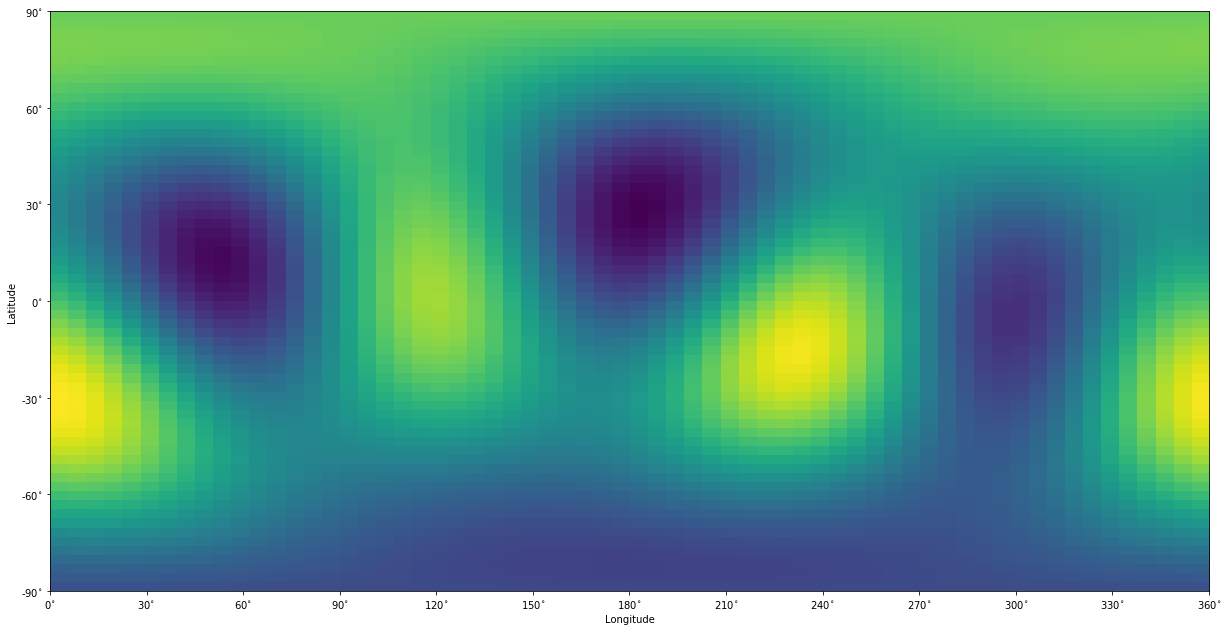

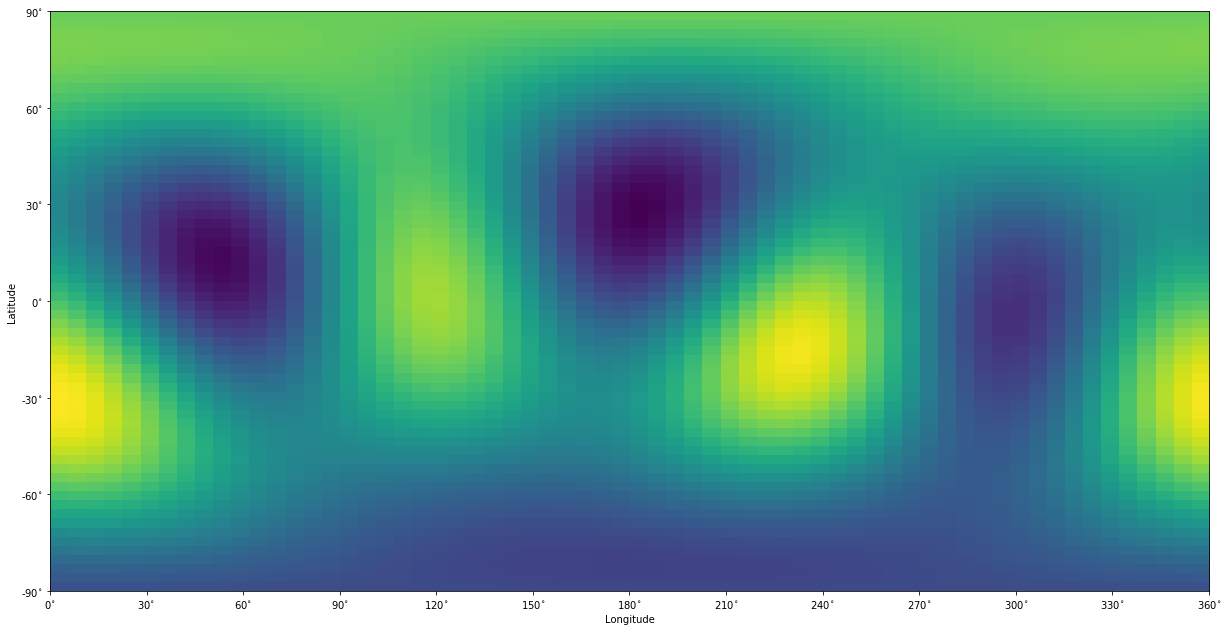

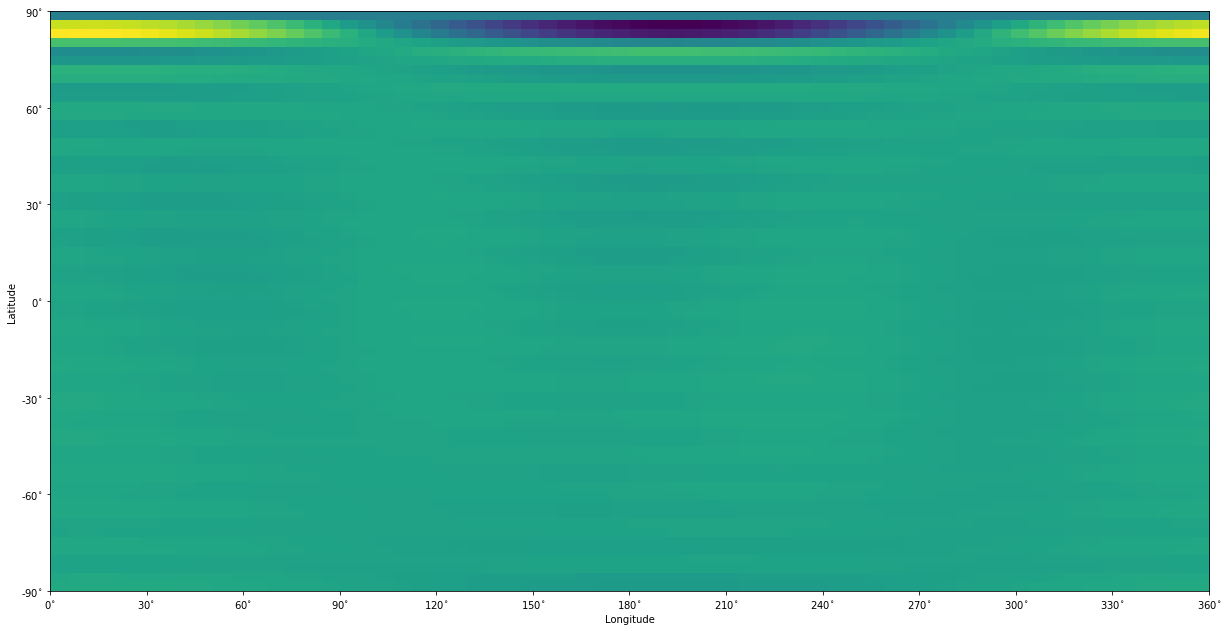

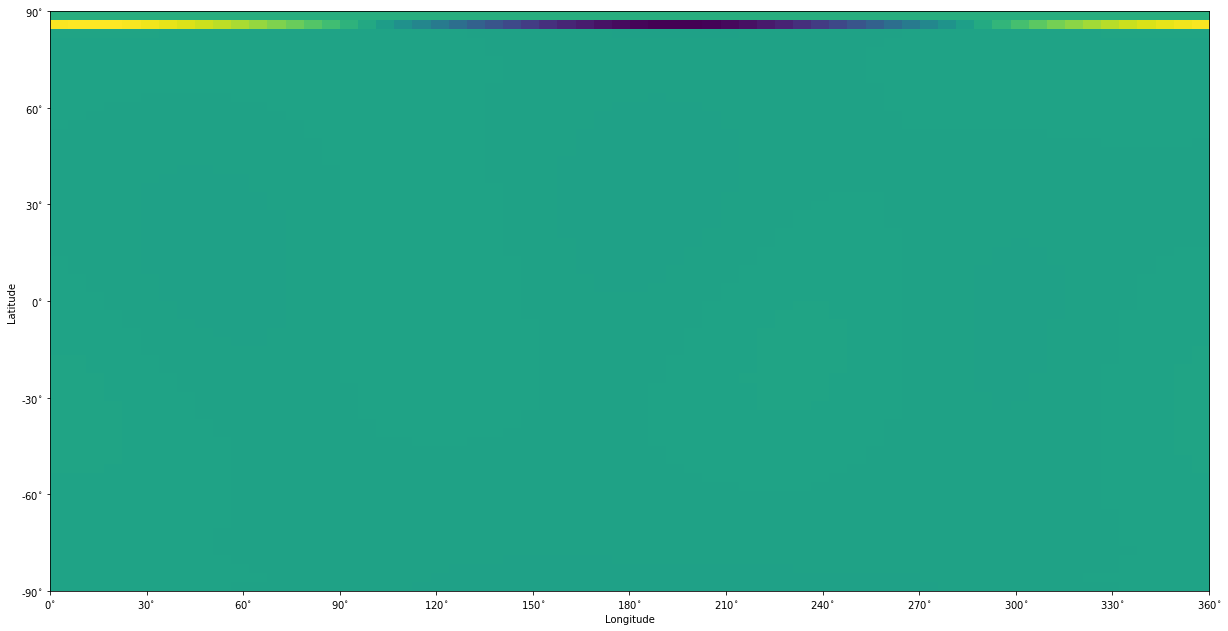

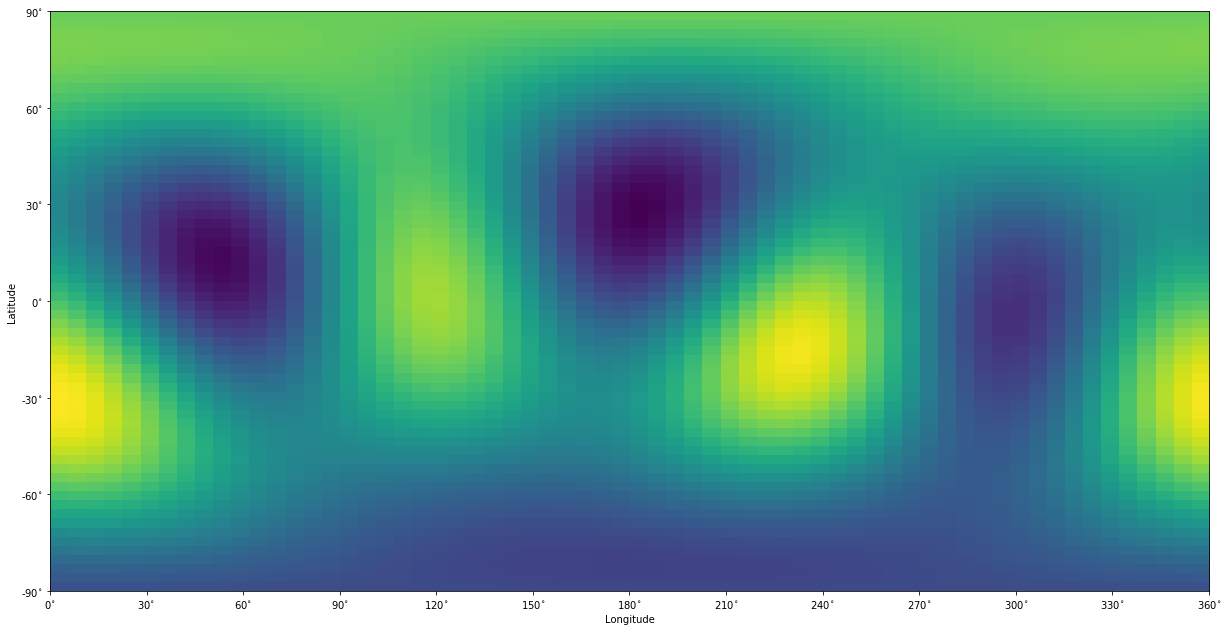

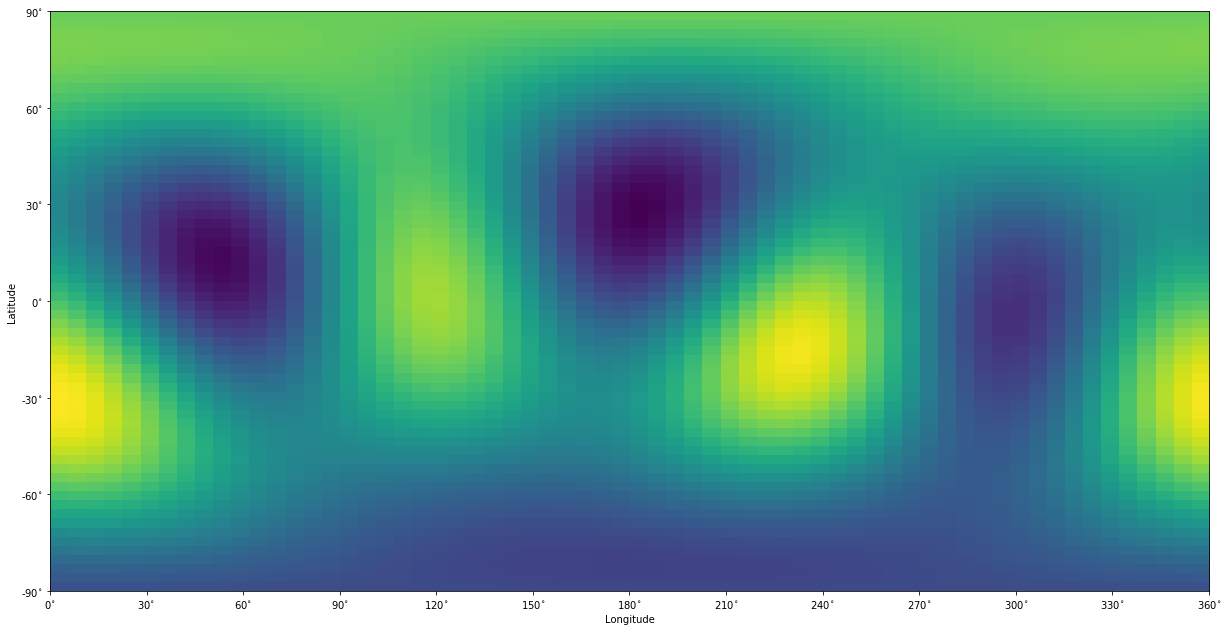

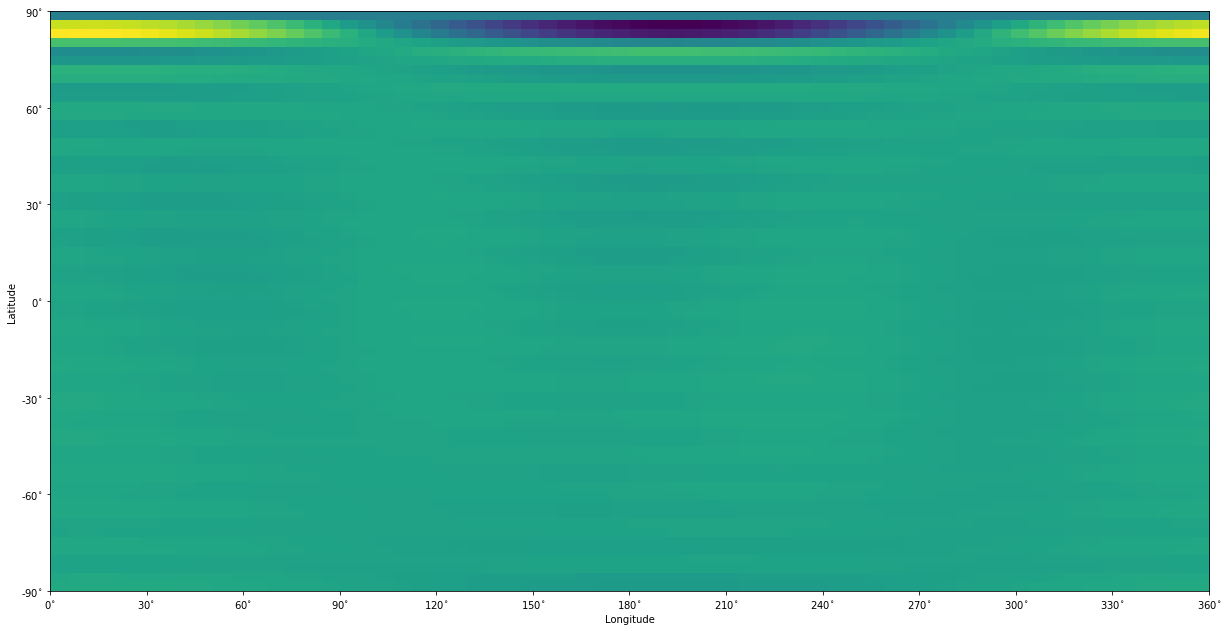

KeyboardInterrupt: 

In [38]:
def _equivariance_error(clm, max_iter, _filter, plot, save, degree):
    """Calculates the equivariance error on one signal  only
    as average of max_iter random rotations"""
    
    grid = clm.expand()
    angles = np.random.uniform(low=0, high=360, size=(max_iter, 3))
    
    norm = np.zeros(max_iter)
    F_grid = _filter(grid)
    F_clm = F_grid.expand()
    for i, [alpha, beta, gamma] in enumerate(angles):
        #clm_rotated = clm.rotate(alpha, beta, gamma, degrees=True)
        clm_rotated = clm.rotate(0, 0, 0, degrees=True)
        grid_rotated = clm_rotated.expand()
        FR_grid = _filter(grid_rotated)
        
        #RF_clm = F_clm.rotate(alpha, beta, gamma, degrees=True)
        RF_clm = F_clm.rotate(0, 0, 0, degrees=True)
        RF_grid = RF_clm.expand()
        
        if degree:
            grid.plot()
            grid_rotated.plot()
            RF_grid.plot()
            FR_grid.plot()
            plt.show()
        norm[i] = np.linalg.norm(RF_grid.data-FR_grid.data)
    
    initial_norm = np.linalg.norm(F_grid.data)
    return np.mean(norm)/initial_norm


def equivariance_error(max_iter, _filter, plot=False, save=False, degree=None):
    """Calculates the equivariance error on max_iter signals
    with the same power spectrum as average of N random rotations each"""
    N = 5
    np.random.seed(seed=1994)
    degrees = np.arange(lmax, dtype=float)
    
    degrees[0] = np.inf
    power = np.ones(lmax) ## to calculate the result in the thesis
    if plot:
        power = degrees**(-3) ## just for plotting
    if degree is not None:
        assert degree < lmax
        power = np.zeros(lmax)
        power[degree] = 1
    norm = np.zeros(max_iter)
    for i in range(max_iter):
        if not i:
            norm[i] = 0.
        else:
            clm = pyshtools.SHCoeffs.from_random(power)
            norm[i] = _equivariance_error(clm, N, _filter, plot, save, degree)
            
    return np.mean(norm)

degree_step = {
    4: 1,
    8: 2,
    16: 4,
    32: 3,
    64: 6,
    128: 12,
    256: 25,
    512: 50,
}

bws = [32, 64, 128]


equiv_error = dict()

for bw in bws:
    lmax = bw
    
    sphere = SphereEquiangularFrossard(bw=bw, lap_type='combinatorial')
    KF = sphere.L

    def _filter_KF(grid):
        array = grid.data
        f = array.flatten()
        ### here goes the filtering ###
        f = KF@f
        ### ----------------------- ###
        array = np.resize(f, array.shape)
        return pyshtools.SHGrid.from_array(array)
    
    degrees = np.arange(0, lmax, degree_step[bw])    
    
    equiv_error[bw] = np.zeros(len(degrees))
    for i, degree in enumerate(degrees):
        equiv_error[bw][i] = equivariance_error(20, _filter_KF, plot=False, save=False, degree=degree)
    plt.plot(degrees, equiv_error[bw], 'o-', label='bw={}'.format(bw))
    
plt.xlabel('Degree', fontdict=font)
plt.ylabel('Equivariance Error', fontdict=font)
plt.title('Khasanova-Frossard graph on equiangular sampling', fontdict=font)
plt.grid()
plt.legend()

filename = "khasanova_frossard.pickle"
filehandler = open(filename, 'wb') 
pickle.dump(equiv_error, filehandler)